In [103]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [83]:
# Step 1: Download Stock Data

# Choose a stock ticker symbol
ticker = 'SCB.BK'

# Download historical data from Yahoo Finance and show adjusted close price (period="6mo")
data = yf.download(ticker, start='2020-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'), auto_adjust=True)

# Focus on Adj. Close prices for simplicity
data = data[['Close']]
print(data)

[*********************100%***********************]  1 of 1 completed

Price            Close
Ticker          SCB.BK
Date                  
2022-04-20   68.347870
2022-04-27   95.603157
2022-04-28   94.345222
2022-04-29   96.441788
2022-05-03   98.538338
2022-05-05   96.861076
2022-05-06   95.183838
2022-05-09   92.667976
2022-05-10   94.764519
2022-05-11   94.345222
2022-05-12   91.410034
2022-05-13   90.152092
2022-05-17   90.571419
2022-05-18   92.248657
2022-05-19   90.571419
2022-05-20   93.506592
2022-05-23   96.441788
2022-05-24   93.087280
2022-05-25   90.990715
2022-05-26   91.829338
2022-05-27   93.087280
2022-05-30   94.345222
2022-05-31   94.764519
2022-06-01   93.506592
2022-06-02   92.667976
2022-06-06   92.248657
2022-06-07   90.990715
2022-06-08   91.410034
2022-06-09   94.764519
2022-06-10   93.506592
2022-06-13   90.571419
2022-06-14   90.152092
2022-06-15   91.410034
2022-06-16   88.894157
2022-06-17   88.894157
2022-06-20   86.378288
2022-06-21   88.055534
2022-06-22   85.539665
2022-06-23   85.539665
2022-06-24   87.216911
2022-06-27 

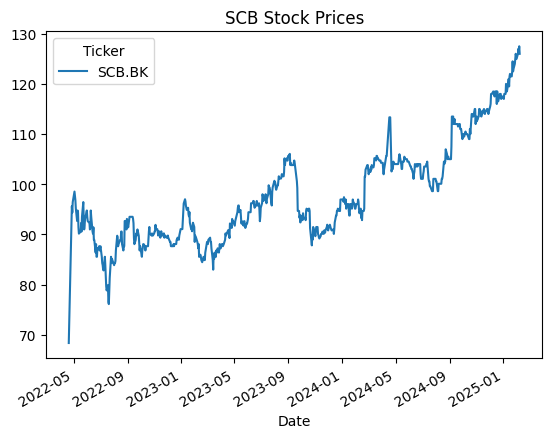

In [85]:
data['Close'].plot()
plt.title("SCB Stock Prices")
plt.show()

In [93]:
# Step 2: Preprocess Data

# Initialize MinMaxScaler to normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# Scale the data for training
scaled_data = scaler.fit_transform(data)

# Handle missing values by forward filling
data.fillna(method='ffill', inplace=True)

# Convert data to pandas DataFrame for further processing if needed
processed_data = pd.DataFrame(scaled_data, columns=['Close'])
print(processed_data)

        Close
0    0.000000
1    0.460766
2    0.439500
3    0.474943
4    0.510387
5    0.482032
6    0.453677
7    0.411145
8    0.446588
9    0.439500
10   0.389879
11   0.368613
12   0.375702
13   0.404056
14   0.375702
15   0.425322
16   0.474943
17   0.418234
18   0.382790
19   0.396967
20   0.418234
21   0.439500
22   0.446588
23   0.425322
24   0.411145
25   0.404056
26   0.382790
27   0.389879
28   0.446588
29   0.425322
30   0.375702
31   0.368613
32   0.389879
33   0.347347
34   0.347347
35   0.304814
36   0.333169
37   0.290637
38   0.290637
39   0.318992
40   0.318992
41   0.326080
42   0.311903
43   0.318992
44   0.326080
45   0.290637
46   0.269371
47   0.262282
48   0.248105
49   0.244560
50   0.290637
51   0.262282
52   0.191395
53   0.177218
54   0.194939
55   0.138230
56   0.131141
57   0.177218
58   0.219750
59   0.290637
60   0.269371
61   0.283548
62   0.262282
63   0.269371
64   0.269371
65   0.276460
66   0.311903
67   0.361524
68   0.354435
69   0.326080
70   0

/var/folders/0j/md5_rxb50xlcmm01jv8lyfmr0000gn/T/ipykernel_78248/1622643600.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [97]:
# Step 3: Prepare Training Data

# Split into the training and testing sets
train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

# Create empty lists for features (x_train) and target (y_train)
x_train = []
y_train = []
x_test = []
y_test = []

# Populate x_train with 60 days of data and y_train with the following day’s closing price
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # Past 60 days
    y_train.append(train_data[i, 0])       # Target: the next day’s close price

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare the test set in the same way
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])  # Past 60 days
    y_test.append(test_data[i, 0])       # Target: the next day’s close price

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [99]:
# Step 4: Build LSTM Model

# Create the LSTM model
model = Sequential()

# First LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Third LSTM layer with 50 units and return sequences=False
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Dense layer with 25 units
model.add(Dense(units=25))

# Output layer with 1 unit (the predicted price)
model.add(Dense(units=1))

# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

/Users/fah/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# Step 5: Train the Model

# Add EarlyStopping to monitor the loss and stop training if it doesn’t improve
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Save the best model during training using ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True)

# Train the model with batch size of 32 and for 50 epochs (can be adjusted)
history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stop, model_checkpoint], validation_split=0.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0608 - val_loss: 0.0318
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0043 - val_loss: 0.0085
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0

In [111]:
# Step 6: Generate predictions for 30-day forecast

# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

# Reshape last_60_days to fit the model input shape
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list
    
    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

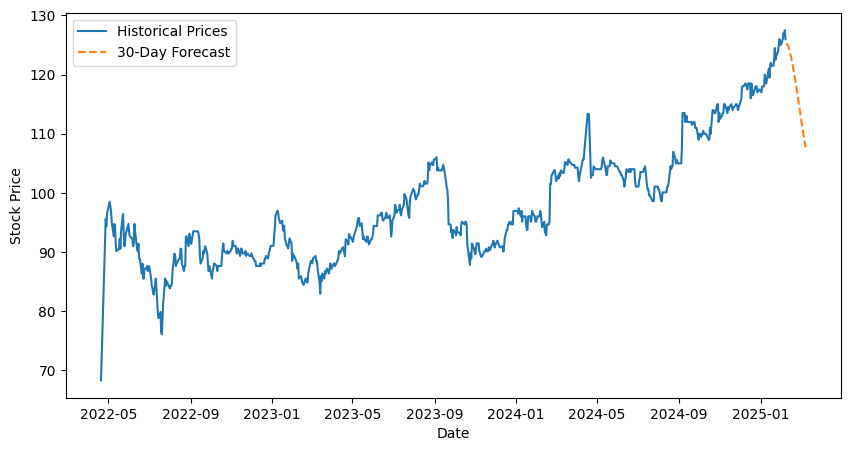

In [117]:
# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(predictions_df, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()